<a href="https://colab.research.google.com/github/sanislearning/ml_playground/blob/main/IMDBRatings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report,accuracy_score,f1_score

In [2]:
from google.colab import files
uploaded=files.upload()

Saving aclImdb.zip to aclImdb.zip


In [3]:
import zipfile
with zipfile.ZipFile('aclImdb.zip','r') as zip_ref:
  zip_ref.extractall()

In [4]:
import os
print(os.listdir('aclImdb'))

['README', 'test', 'imdbEr.txt', 'train', 'imdb.vocab']


In [5]:
def load_reviews(directory,label):
  reviews=[]
  for filename in os.listdir(directory): #loops through all the files in the directory
    file_path=os.path.join(directory,filename) #gets the complete path to each review file
    with open(file_path,encoding='utf-8') as file: #Open file and read using UTF-8 encoding
      reviews.append((file.read(),label))
  return reviews

pos_reviews=load_reviews('aclImdb/train/pos',1) #loads positive reviews and assign them to the label 1
neg_reviews=load_reviews('aclImdb/train/neg',0) #loads negative reviews and assigns them to the label 0

In [6]:
all_reviews=pos_reviews+neg_reviews
import random
random.shuffle(all_reviews) #mixes up the dataset so positive and negative reviews are mixed

In [7]:
df=pd.DataFrame(all_reviews,columns=['review','label'])
print(df.head())
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(
    df['review'],df['label'],test_size=0.2,random_state=42
)

                                              review  label
0  I love Seth Green. His appearances on THat 70s...      0
1  Thomas Capano was not Anne Marie's boss Tom Ca...      1
2  Sure, the history in this movie was "Hollywood...      1
3  To call a movie like "Thinner" bad is like cal...      0
4  I was 5 years old when I saw this musical movi...      1


#Training the Naive Bayes Classifer

In [8]:
#Since we have natural language text on one side and we need to train a model,
#we have to convert it into a numerical format that ML models can work with
from sklearn.feature_extraction.text import TfidfVectorizer #Term frequency inverse document frequency
vectorizer=TfidfVectorizer(stop_words='english',max_features=10000)
x_train_vec=vectorizer.fit_transform(x_train) #Learns the vocabulary and IDF weights from xtrain, converts each review into TFIDF weighted feature vector based on this learned vocabulary.
x_val_vec=vectorizer.transform(x_val)
#TF = Frequency of word in the document.
#IDF = log(Total docs / Docs containing the word).
#TFIDF= TF*IDF.


In [9]:
from sklearn.naive_bayes import MultinomialNB

model=MultinomialNB()
model.fit(x_train_vec,y_train)
y_pred=model.predict(x_val_vec)
print("Accuracy: ",accuracy_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

Accuracy:  0.85
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2510
           1       0.85      0.85      0.85      2490

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [10]:
#Using CountVectorizer instead of TFIDF
#Checks how many times each word appears in a document
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(stop_words='english',max_features=10000)
x_train_vec=vectorizer.fit_transform(x_train)
x_val_vec=vectorizer.transform(x_val) #transform using same vocabulary

In [11]:
nbmodel=MultinomialNB()
nbmodel.fit(x_train_vec,y_train)
y_pred=nbmodel.predict(x_val_vec)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.8434
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      2510
           1       0.85      0.83      0.84      2490

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



#Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

lr_model=LogisticRegression(max_iter=1000)
lr_model.fit(x_train_vec,y_train)
y_pred=lr_model.predict(x_val_vec)

print("Logistic Regression Accuracy: ",accuracy_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

Logistic Regression Accuracy:  0.8706
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2510
           1       0.86      0.88      0.87      2490

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



#Long Short Term Memory


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
#It converts text into sequences of integers
tokenizer=Tokenizer(num_words=10000,oov_token="<OOV>")
#num_words- top how many common words will be used
#oov_token- replaces out of vocabulary words with this
tokenizer.fit_on_texts(x_train)

In [15]:
x_train_seq=tokenizer.texts_to_sequences(x_train)
x_val_seq=tokenizer.texts_to_sequences(x_val)

In [23]:
#Padding the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len=200
x_train_pad=pad_sequences(x_train_seq,maxlen=max_len,padding='post',truncating='post')
#every review is padded to or trimmed to 200 tokens
#post means if padding needed add zeros at end, if sequence longer cut off the end
x_val_pad=pad_sequences(x_val_seq,maxlen=max_len,padding='post',truncating='post')

In [24]:
#Building the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense

model_lstm=Sequential([
    Embedding(input_dim=10000,output_dim=64,input_length=max_len),
    #input dim is vocabulary size
    LSTM(64, return_sequences=False),
    Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_obj=model_lstm.fit(x_train_pad,y_train,epochs=5,batch_size=128,validation_data=(x_val_pad,y_val))

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 499ms/step - accuracy: 0.8304 - loss: 0.4295 - val_accuracy: 0.8092 - val_loss: 0.4709
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 435ms/step - accuracy: 0.8521 - loss: 0.3809 - val_accuracy: 0.7804 - val_loss: 0.5179
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 390ms/step - accuracy: 0.8559 - loss: 0.3740 - val_accuracy: 0.8116 - val_loss: 0.4868
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 384ms/step - accuracy: 0.8694 - loss: 0.3502 - val_accuracy: 0.8016 - val_loss: 0.5123
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 420ms/step - accuracy: 0.8614 - loss: 0.3686 - val_accuracy: 0.7896 - val_loss: 0.5289


In [33]:
loss, accuracy = model_lstm.evaluate(x_val_pad, y_val)
print(f"Final Validation Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8018 - loss: 0.5131
Final Validation Accuracy: 0.7896


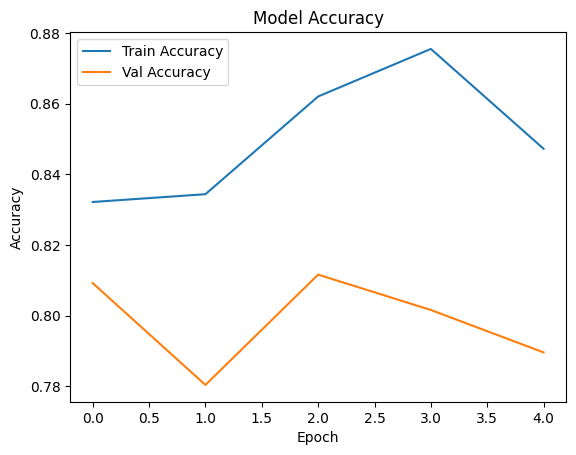

In [34]:
history = history_obj.history
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()